In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [79]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [80]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [81]:
torch.manual_seed(42)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.std(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        normalized_x = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * normalized_x + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * xmean
                self.running_var = self.momentum * self.running_var + (1 - self.momentum) * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.C = torch.randn((vocab_size, n_embd))
        
    def __call__(self, IX):
        self.out = self.C[IX]
        return self.out
    
    def parameters(self):
        return [self.C]

class FlattenConsecutive:
    def __init__(self, group_of_n_chars):
        self.n = group_of_n_chars
        
    def __call__(self, x):
        B, C, emb_size = x.shape
        x = x.view(B, C//self.n, self.n*emb_size)
        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [82]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
chars_grouped_together = 2

C = torch.randn((vocab_size, n_embd)) # the character embedding matrix
model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(chars_grouped_together), Linear((n_embd * chars_grouped_together), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),     # first hidden layer
    FlattenConsecutive(chars_grouped_together), Linear((n_hidden * chars_grouped_together), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),   # second hidden layer
    FlattenConsecutive(chars_grouped_together), Linear((n_hidden * chars_grouped_together), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),   # third hidden layer
    Linear(n_hidden, vocab_size)                                                        # the output layer of the MLP
])        

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # making last layer less confident at initialization

parameters = model.parameters()
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") 

for p in parameters:
    p.requires_grad = True

Total number of parameters: 76579


In [83]:
steps=200000
batch_size=32
lossi = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    xb, yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(xb)
    
    loss = F.cross_entropy(logits, yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # gradient descent
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 
        
    # stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f"{i:7d}/{steps:7d}:  {loss.item():.4f}")
    
    # break

      0/ 200000:  3.2956
  10000/ 200000:  1.4400
  20000/ 200000:  1.9523
  30000/ 200000:  2.0583
  40000/ 200000:  1.5619
  50000/ 200000:  1.9991
  60000/ 200000:  1.8596
  70000/ 200000:  1.7440
  80000/ 200000:  2.1511
  90000/ 200000:  1.5004
 100000/ 200000:  1.9331
 110000/ 200000:  1.6963
 120000/ 200000:  2.1730
 130000/ 200000:  2.0818
 140000/ 200000:  1.8729
 150000/ 200000:  1.9114
 160000/ 200000:  1.5779
 170000/ 200000:  1.6249
 180000/ 200000:  1.5197
 190000/ 200000:  1.6329


In [66]:
for layer in model.layers:
    print(f"for layer: {layer.__class__.__name__} output shape is: {layer.out.shape}")

for layer: Embedding output shape is: torch.Size([32, 8, 10])
for layer: FlattenConsecutive output shape is: torch.Size([32, 4, 20])
for layer: Linear output shape is: torch.Size([32, 4, 68])
for layer: BatchNorm1d output shape is: torch.Size([32, 4, 68])
for layer: Tanh output shape is: torch.Size([32, 4, 68])
for layer: FlattenConsecutive output shape is: torch.Size([32, 2, 136])
for layer: Linear output shape is: torch.Size([32, 2, 68])
for layer: BatchNorm1d output shape is: torch.Size([32, 2, 68])
for layer: Tanh output shape is: torch.Size([32, 2, 68])
for layer: FlattenConsecutive output shape is: torch.Size([32, 136])
for layer: Linear output shape is: torch.Size([32, 68])
for layer: BatchNorm1d output shape is: torch.Size([32, 68])
for layer: Tanh output shape is: torch.Size([32, 68])
for layer: Linear output shape is: torch.Size([32, 27])


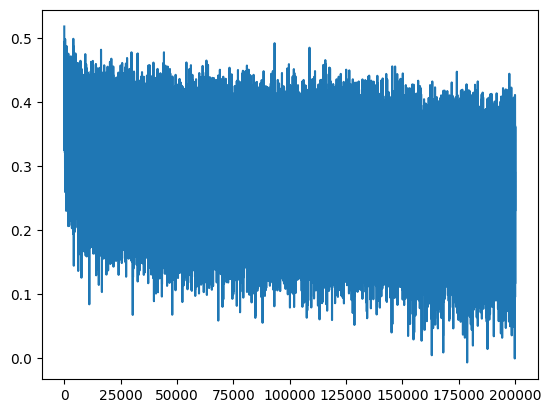

In [84]:
# raw lossi plot. reading vary a lot due to small batch size
plt.plot(lossi)

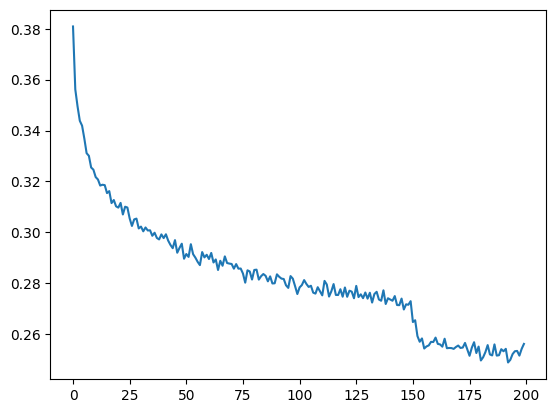

In [85]:
# ploting mean loss for every 1000 steps by converting lossi list into tensor and reshaping to view 1000 steps loss in each row and taking its mean
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1)) 

In [86]:
# eval mode
for layer in model.layers:
    layer.training = False

In [87]:
# calculating training and val loss

torch.no_grad()
def print_overall_loss(split):
    x , y = {'train':(Xtr, Ytr), 'dev':(Xdev, Ydev), 'test':(Xte, Yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")

print_overall_loss('train')
print_overall_loss('dev')    

train loss: 1.7998
dev loss: 2.0246


In [88]:
# generating samples

for i in range(10):
    out = ''
    context = [0] * block_size
    while True:
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        out += itos[ix]
        context = context[1:] + [ix]
        if ix == 0:
            print(f"{i} : {out}")
            break
        

0 : kelsan.
1 : zaharian.
2 : arriston.
3 : jahce.
4 : cyrey.
5 : dane.
6 : tanyla.
7 : bretin.
8 : kakiya.
9 : savina.


In [ ]:
# baseline:
# train loss: 2.0804
# dev loss: 2.1296

# wavenet 22k params with batchnorm fixed:
# train loss: 1.9414
# dev loss: 2.0557

# optim wavenet:
train loss: 1.7998
dev loss: 2.0246